In [1]:
import sys
import os

# Get the absolute path of the parent directory.
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Add the parent directory to the system path to be able to import modules from 'lib.'
sys.path.append(parent_dir)

In [2]:
import datasets

import ipywidgets as widgets
from IPython.display import HTML, Markdown as md
import itertools

from lib.memory import DSDM
from lib.utils import cleanup, configs, inference, learning, preprocess, utils 

import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import numpy as np
import random

import pandas as pd
import pathlib

import seaborn as sns

from transformers import AutoTokenizer, AutoModel

import torch
import torchhd as thd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F 

from tqdm import tqdm

### Package options ###
torch.set_printoptions(threshold=10_000)

[nltk_data] Downloading package punkt to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
### Utils ###
def plot_heatmap(x: np.array, labels: np.array) -> None:
    plt.figure(figsize=(15, 15))
    sns.heatmap(
        x,
        linewidth=0.5,
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
        fmt='.2f',
    )
    plt.title(f'Self-attention matrix: layer {layer}, head {head}', fontsize=15)
    
    plt.show()
    return


# TODO: Split into two functions! Because, right now, we are both changing the underlying tensor AND asgining it a new value.
def average_out_and_remove_consecutive_duplicates(t: torch.tensor, averages_idx):
    for average_idx in averages_idx:  # The nested lists can have different dimensions.
        t[average_idx] = torch.mean(t[average_idx], dim=0, keepdim=True)
    return torch.unique_consecutive(t, dim=0)
    

def backward_pass(G, current_node, left_edge, right_edge, sequence):
    in_nodes = np.array([edge[0] for edge in list(G.in_edges(current_node))])
    in_nodes = in_nodes[(in_nodes > left_edge) & (in_nodes < current_node)]
    for node in in_nodes:
        sequence[node] = 1
        sequences.append(sequence)
        backward_pass(G, node, left_edge, node, sequence.copy())
        forward_pass(G, node, left_edge, current_node, sequence.copy())
        
    return
    
    
def forward_pass(G, current_node, left_edge, right_edge, sequence):
    out_nodes = np.array([edge[1] for edge in list(G.out_edges(current_node))])
    out_nodes = out_nodes[(out_nodes > current_node) & (out_nodes < right_edge)]
    for node in out_nodes:
        sequence[node] = 1
        sequences.append(sequence)
        backward_pass(G, node, current_node, node, sequence.copy())
        forward_pass(G, node, node, right_edge, sequence.copy())
            
    return
    

def construct_sequences(G: nx.DiGraph, n_tokens):
    for node in G.nodes():
        sequence = np.zeros(n_tokens)
        sequence[node] = 1
        #sequences.append(sequence) # Do not allow for 1-token sequences.
        forward_pass(G, node, node, n_tokens, sequence.copy())

In [4]:
# Load Wikipedia dataset.
# TODO: Split between server and local.
#wiki_dataset = datasets.load_dataset("wikipedia", "20220301.en")['train']
wiki_dataset = datasets.load_dataset(
    "wikipedia",
    "20220301.en",
    cache_dir="/nfs/data/projects/daniela")['train']

Found cached dataset wikipedia (/nfs/data/projects/daniela/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed.
utils.fix_seed(41)

Using seed: 41

In [6]:
# Set DSDM hyperparameters.
address_size = 1000
ema_time_period = 5000
learning_rate_update = 0.5

temperature = 0.05

normalize = False

#chunk_sizes = [5]

prune_mode = "fixed-size"
max_size_address_space = 10000

In [7]:
cleanup = cleanup.Cleanup(address_size)

In [8]:
model_name = "bert-base-uncased"  # Has 12 layers
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

MAXIMUM_SEQUENCE_LENGTH = 512

In [9]:
# Initialize memory.
memory = DSDM.DSDM(
    address_size=address_size,
    ema_time_period=ema_time_period,
    learning_rate_update=learning_rate_update,
    temperature=temperature,
    normalize=normalize,
    prune_mode=prune_mode,
    max_size_address_space=max_size_address_space
) 

In [10]:
# Construct train set (texts) and inference set (sentences; in and out of train set text).
train_size = 250
test_size = 10

# Text indeces.
train_idx = np.random.randint(0, len(wiki_dataset), size=train_size)

# Caclulate chosen text statistics.
# TODO

# Text indeces from which we extract sentences.
intest_idx = np.random.choice(train_idx, test_size)
outtest_idx = np.random.choice(np.setdiff1d(np.arange(len(wiki_dataset)), train_idx), test_size)

In [11]:
inference_sentences_in = []
inference_sentences_out = []

for idx_in, idx_out in zip(intest_idx, outtest_idx):
    # Get sentences.
    sentences_in = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_in)]['text'])
    sentences_out = utils.preprocess.split_text_into_sentences(wiki_dataset[int(idx_out)]['text'])
    
    # Get sentence index.
    sentence_idx_in = int(
        np.random.randint(
            0,
            len(sentences_in),
            size=1
        )
    )
    sentence_idx_out = int(
        np.random.randint(
            0,
            len(sentences_out),
            size=1
        )
    )

    # Append sentence to list.
    inference_sentences_in.append(sentences_in[sentence_idx_in])
    inference_sentences_out.append(sentences_out[sentence_idx_out])

In [14]:
# Training
for i in tqdm(train_idx):
    text = wiki_dataset[int(i)]['text']
    
    # Preprocess data. 
    sentences = preprocess.split_text_into_sentences(text)
    
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt")
        if inputs['input_ids'].shape[1] > MAXIMUM_SEQUENCE_LENGTH:
            break
        
        outputs = model(**inputs, output_attentions=True)
        attention_matrix = outputs.attentions
        
        encoding = tokenizer.encode(sentence)
        labels = tokenizer.convert_ids_to_tokens(encoding)

        i = 0
        averages_idx = []
        while i < len(labels) - 1:
            j = i + 1
            average_idx = []
            while labels[j].startswith('#'):
                average_idx.append(j)
                labels[i] += labels[j].replace('#', '')
                j += 1
            if average_idx != []:
                average_idx.append(i)
                averages_idx.append(average_idx)
            i = j
        
        hashtag_idx = np.array([label.startswith("#") for label in labels])
        labels = np.array(labels)[~hashtag_idx]
        labels = labels[1:(len(labels) - 1)]

        layer = 0
        for head in range(12):
            head_scores_raw_tensor = attention_matrix[layer][0][head].detach().clone()
            
            head_scores_raw_tensor = average_out_and_remove_consecutive_duplicates(head_scores_raw_tensor, averages_idx) # Row-wise avraging and duplicates removal

            # Tranpose the result of the column-wise averaging and duplicates removal applied to transposed tensor.
            head_scores_raw_tensor = torch.transpose(
                average_out_and_remove_consecutive_duplicates(torch.transpose(head_scores_raw_tensor, 0, 1), averages_idx),
                0,
                1
            ) 

            head_scores_raw_tensor = torch.unique_consecutive(head_scores_raw_tensor, dim=0)
            
            head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()
            
            head_scores = head_scores_raw[1:(len(head_scores_raw) - 1), 1:(len(head_scores_raw) - 1)].copy()
        
            as_threshold = 0.7
            head_scores[head_scores < as_threshold] = 0
            
            G = nx.from_numpy_array(head_scores, create_using = nx.DiGraph())
        
            sequences = []
            n_tokens = len(labels)
            construct_sequences(G, n_tokens)

            for sequence in sequences:
                memory.save(
                    inference.generate_query(
                        address_size,
                        cleanup,
                        labels[sequence.astype(bool)]
                    )
                )
        memory.prune()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:49<00:00,  1.40s/it]


In [49]:
inference_sentences_in = ["The Society convenes an annual conference, in locations across the United States and in Canada, usually in June, to convey the James Alice award."]
#inference_sentences_in = ["the James Alice award."]

In [51]:
retrieve_mode = "top_k"

# Get table with token similarities for each "out-of-train" sentence.
retrieved_contents = inference.infer(
    memory.address_size,
    cleanup,
    memory,
    inference_sentences_in,
    retrieve_mode=retrieve_mode,
    k=5, #TODO: What if index is out of range?
)

if retrieve_mode == "top_k":
    sims_df = pd.DataFrame(columns=['sentence', 'token', 'similarity']) 
    
    for s, addresses in zip(inference_sentences_in, retrieved_contents):
        display(s)
        out_tables = []
        for a in addresses:
            address_sims_df = inference.get_similarities_to_atomic_set(
                a, cleanup)
            out = widgets.Output()
            with out:
                display(address_sims_df)
            out_tables.append(out)
        display(widgets.HBox(out_tables))
elif retrieve_mode == "pooling":  
    sims_df = pd.DataFrame(columns=['sentence', 'token', 'similarity']) 
      
    for s, c in zip(inference_sentences_in, retrieved_contents):
        sentence_sims_df = inference.get_similarities_to_atomic_set(
            c, cleanup)
        sentence_sims_df['sentence'] = [s] * len(sentence_sims_df)
        sims_df = pd.concat([sims_df, sentence_sims_df])

    sims_df = sims_df.sort_values(['sentence', 'similarity'], ascending=False) \
                     .set_index(['sentence', 'token'])
    
    display(sims_df)
else:  # unrecognized
    pass

'The Society convenes an annual conference, in locations across the United States and in Canada, usually in June, to convey the James Alice award.'

In [17]:
addresses = np.random.randint(0, len(memory.addresses), size=30)

for address in addresses:
    display(md(f"### Address {address}"))
    address_sims_df = inference.get_similarities_to_atomic_set(
            memory.addresses[address],
            cleanup,
    )
    display(address_sims_df)

### Address 255

,token,similarity
0,is,0.698948
1,located,0.695220
2,from,0.192627
3,nonprofit,0.110473
4,areas,0.106948
5,lover,0.104717
6,158,0.104511
7,crowds,0.103789
8,finite,0.103224
9,kill,0.101717


### Address 7031

,token,similarity
0,-,0.746067
1,release,0.703643
2,games,0.118834
3,usually,0.118206
4,motorcycles,0.118153
5,evil,0.116304
6,astronomer,0.108795
7,alphabet,0.104661
8,sonny,0.102388
9,laced,0.099850


### Address 30

,token,similarity
0,is,0.725116
1,marked,0.700117
2,combat,0.115494
3,cultural,0.115483
4,directors,0.106450
5,accommodate,0.104457
6,northumberland,0.104072
7,sketches,0.103640
8,arc,0.103206
9,souls,0.098550


### Address 9141

,token,similarity
0,of,0.700015
1,project,0.696143
2,american,0.141389
3,journeys,0.102567
4,spending,0.101803
5,andy,0.101082
6,studies,0.099685
7,comparisons,0.096993
8,peers,0.096030
9,havana,0.095461


### Address 6087

,token,similarity
0,to,0.722537
1,guide,0.685515
2,through,0.122279
3,graphic,0.112591
4,bench,0.111639
5,waves,0.103316
6,raids,0.102661
7,subdivisions,0.100252
8,minutes,0.098474
9,60,0.097672


### Address 6721

,token,similarity
0,–,0.679525
1,1907,0.670219
2,),0.181487
3,progression,0.106935
4,variability,0.103707
5,hygiene,0.101986
6,birthplace,0.101880
7,dead,0.101184
8,twentieth,0.100939
9,locomotive,0.100738


### Address 517

,token,similarity
0,may,0.731787
1,2007,0.724199
2,carpet,0.112492
3,red,0.104295
4,once,0.104294
5,radical,0.101876
6,empirical,0.101831
7,dedicated,0.098978
8,midsummer,0.098731
9,consulting,0.096626


### Address 1737

,token,similarity
0,to,0.786997
1,reported,0.590223
2,be,0.215325
3,exam,0.112566
4,star,0.108098
5,survive,0.105969
6,domestic,0.097473
7,weekend,0.097243
8,1913,0.096218
9,book,0.096116


### Address 5871

,token,similarity
0,the,0.703917
1,presence,0.672454
2,newspapers,0.125184
3,starting,0.108866
4,example,0.104076
5,minas,0.101853
6,installment,0.101119
7,erie,0.101105
8,rated,0.100796
9,angeles,0.099958


### Address 7516

,token,similarity
0,of,0.693879
1,lines,0.673659
2,fascinated,0.123489
3,longest,0.117280
4,fame,0.116671
5,performer,0.113456
6,hills,0.113256
7,officials,0.110936
8,effect,0.104975
9,knocked,0.104792


### Address 1108

,token,similarity
0,to,0.706775
1,order,0.702911
2,reluctant,0.125227
3,restaurants,0.112901
4,sitcom,0.108431
5,incarnation,0.108130
6,generations,0.107339
7,plasma,0.107305
8,weekend,0.100345
9,barely,0.099828


### Address 9826

,token,similarity
0,",",0.703461
1,opened,0.688615
2,allowing,0.226420
3,images,0.124098
4,office,0.114641
5,enjoying,0.104808
6,-,0.104676
7,hoped,0.102234
8,pictures,0.101911
9,variety,0.101868


### Address 3669

,token,similarity
0,his,0.694947
1,life,0.689237
2,start,0.119880
3,newspaper,0.117170
4,feared,0.105431
5,alec,0.102783
6,terry,0.102503
7,opposite,0.099856
8,1929,0.099650
9,loving,0.099592


### Address 3738

,token,similarity
0,s,0.708179
1,knife,0.698911
2,decide,0.143672
3,trio,0.132064
4,quantity,0.101173
5,contracted,0.100992
6,meyer,0.098528
7,whitman,0.097933
8,piston,0.097630
9,solo,0.095270


### Address 853

,token,similarity
0,),0.694989
1,(,0.694766
2,contractors,0.122362
3,videos,0.119361
4,era,0.111670
5,courageous,0.110424
6,britain,0.109065
7,pen,0.108532
8,searching,0.107667
9,2,0.107597


### Address 8891

,token,similarity
0,making,0.678154
1,upon,0.674637
2,landfall,0.271663
3,dad,0.108837
4,withstand,0.099406
5,broadcast,0.098081
6,shuttle,0.098073
7,badly,0.098069
8,composing,0.096067
9,250,0.096040


### Address 2460

,token,similarity
0,can,0.716136
1,take,0.713529
2,she,0.130277
3,frankfurt,0.110875
4,entertainment,0.110649
5,material,0.102151
6,allen,0.101917
7,formula,0.099411
8,inequality,0.099327
9,energies,0.099301


### Address 5127

,token,similarity
0,lose,0.690051
1,money,0.686104
2,every,0.261214
3,where,0.119382
4,sacred,0.112547
5,strictly,0.111424
6,fc,0.107819
7,bestowed,0.107576
8,week,0.104528
9,sherwood,0.101377


### Address 6019

,token,similarity
0,),0.717103
1,however,0.705517
2,consists,0.151442
3,scattered,0.129373
4,watson,0.126361
5,barely,0.115254
6,videos,0.104595
7,paved,0.104366
8,enrollment,0.104084
9,bit,0.104076


### Address 7714

,token,similarity
0,the,0.700307
1,1974,0.664557
2,national,0.123001
3,michelle,0.121003
4,reportedly,0.117693
5,rated,0.115688
6,backyard,0.114078
7,hardly,0.108637
8,dates,0.105108
9,closely,0.099354


### Address 6485

,token,similarity
0,investment,0.653984
1,technology,0.648572
2,banking,0.309672
3,hidden,0.106999
4,signs,0.104243
5,manhattan,0.102259
6,atletico,0.100819
7,among,0.098897
8,hostility,0.098694
9,impacted,0.097444


### Address 2577

,token,similarity
0,railway,0.696519
1,nearest,0.679788
2,station,0.233620
3,haigler,0.122124
4,1954,0.118603
5,sums,0.101541
6,opted,0.097015
7,biographer,0.095638
8,crushed,0.094701
9,proponent,0.093073


### Address 8887

,token,similarity
0,caused,0.702359
1,about,0.699969
2,$,0.230858
3,intent,0.114124
4,57,0.108450
5,404,0.104083
6,scientific,0.100305
7,champagne,0.099036
8,population,0.096845
9,century,0.096327


### Address 7545

,token,similarity
0,was,0.678593
1,noted,0.654219
2,for,0.349936
3,heading,0.108485
4,spent,0.107820
5,grows,0.106217
6,demise,0.106118
7,go,0.104800
8,cooperation,0.098721
9,81,0.098271


### Address 9388

,token,similarity
0,always,0.670883
1,stated,0.664237
2,that,0.140007
3,pianist,0.129944
4,mad,0.110315
5,composite,0.109281
6,psychiatric,0.107261
7,rage,0.103177
8,tour,0.102703
9,counties,0.100668


### Address 9793

,token,similarity
0,public,0.632230
1,service,0.627310
2,commission,0.432125
3,the,0.108954
4,supreme,0.108797
5,quickly,0.105717
6,known,0.105212
7,catalyst,0.104831
8,all,0.104243
9,recreation,0.102357


### Address 6820

,token,similarity
0,is,0.716369
1,next,0.674076
2,to,0.269861
3,broadly,0.116449
4,pan,0.115488
5,filled,0.101760
6,canons,0.098517
7,sixth,0.097481
8,areas,0.097387
9,sought,0.096850


### Address 3696

,token,similarity
0,is,0.716480
1,convicted,0.694719
2,walt,0.112992
3,growth,0.110235
4,vale,0.107719
5,google,0.102855
6,contributed,0.102280
7,proof,0.102143
8,sudan,0.098384
9,sixth,0.096909


### Address 2728

,token,similarity
0,urban,0.678789
1,american,0.670750
2,planner,0.340637
3,since,0.117081
4,joe,0.115662
5,doubtful,0.108467
6,fifteen,0.102535
7,warn,0.100664
8,management,0.099987
9,steele,0.096046


### Address 8230

,token,similarity
0,",",0.691270
1,1843,0.654526
2,),0.219663
3,schools,0.115942
4,flying,0.113931
5,lips,0.109515
6,1989,0.108597
7,nightmare,0.107644
8,poster,0.106257
9,fireplace,0.104124


## Appendix

In [33]:
text = "Firenze has sold more records than there are bags available."
text = "the james alice award"
inputs = tokenizer(text, return_tensors="pt")

In [34]:
outputs = model(**inputs, output_attentions=True)
attention_matrix = outputs.attentions

In [35]:
encoding = tokenizer.encode(text)
labels = tokenizer.convert_ids_to_tokens(encoding)

In [36]:
token_df = pd.DataFrame(labels, columns=['token']).head(20)
labels = token_df.token.values

In [37]:
i = 0
averages_idx = []
while i < len(labels) - 1:
    j = i + 1
    average_idx = []
    while labels[j].startswith('#'):
        average_idx.append(j)
        labels[i] += labels[j].replace('#', '')
        j += 1
    if average_idx != []:
        average_idx.append(i)
        averages_idx.append(average_idx)
    i = j

hashtag_idx = np.array([label.startswith("#") for label in labels])
labels = np.array(labels)[~hashtag_idx]
labels = labels[1:(len(labels) - 1)]
print(labels)

['the' 'james' 'alice' 'award']


torch.Size([6, 6])
torch.Size([6, 6])


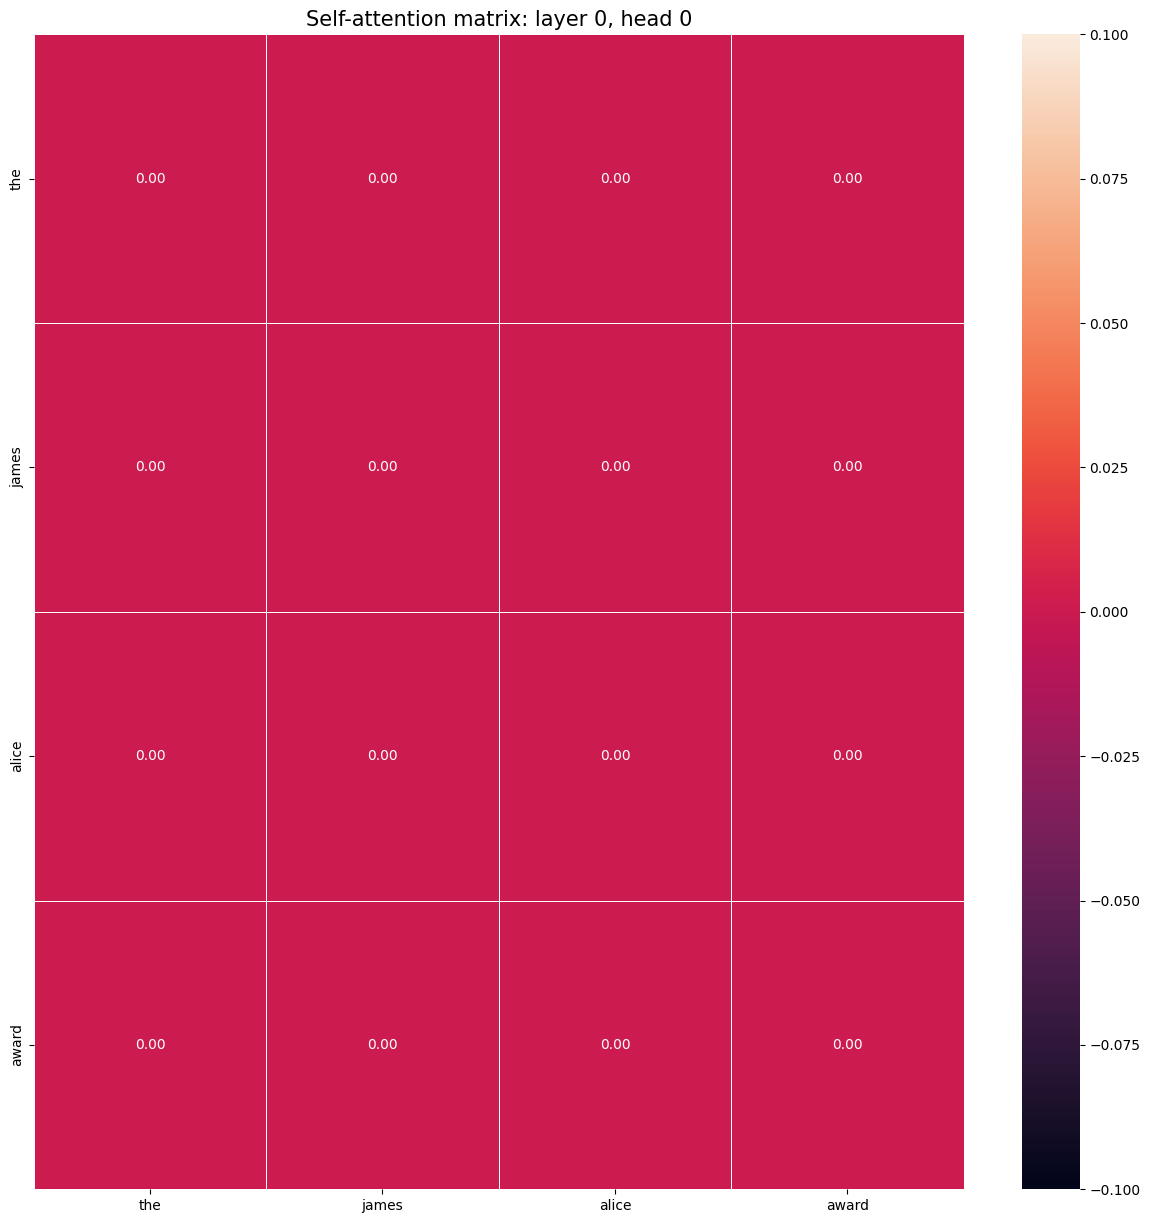

torch.Size([6, 6])
torch.Size([6, 6])


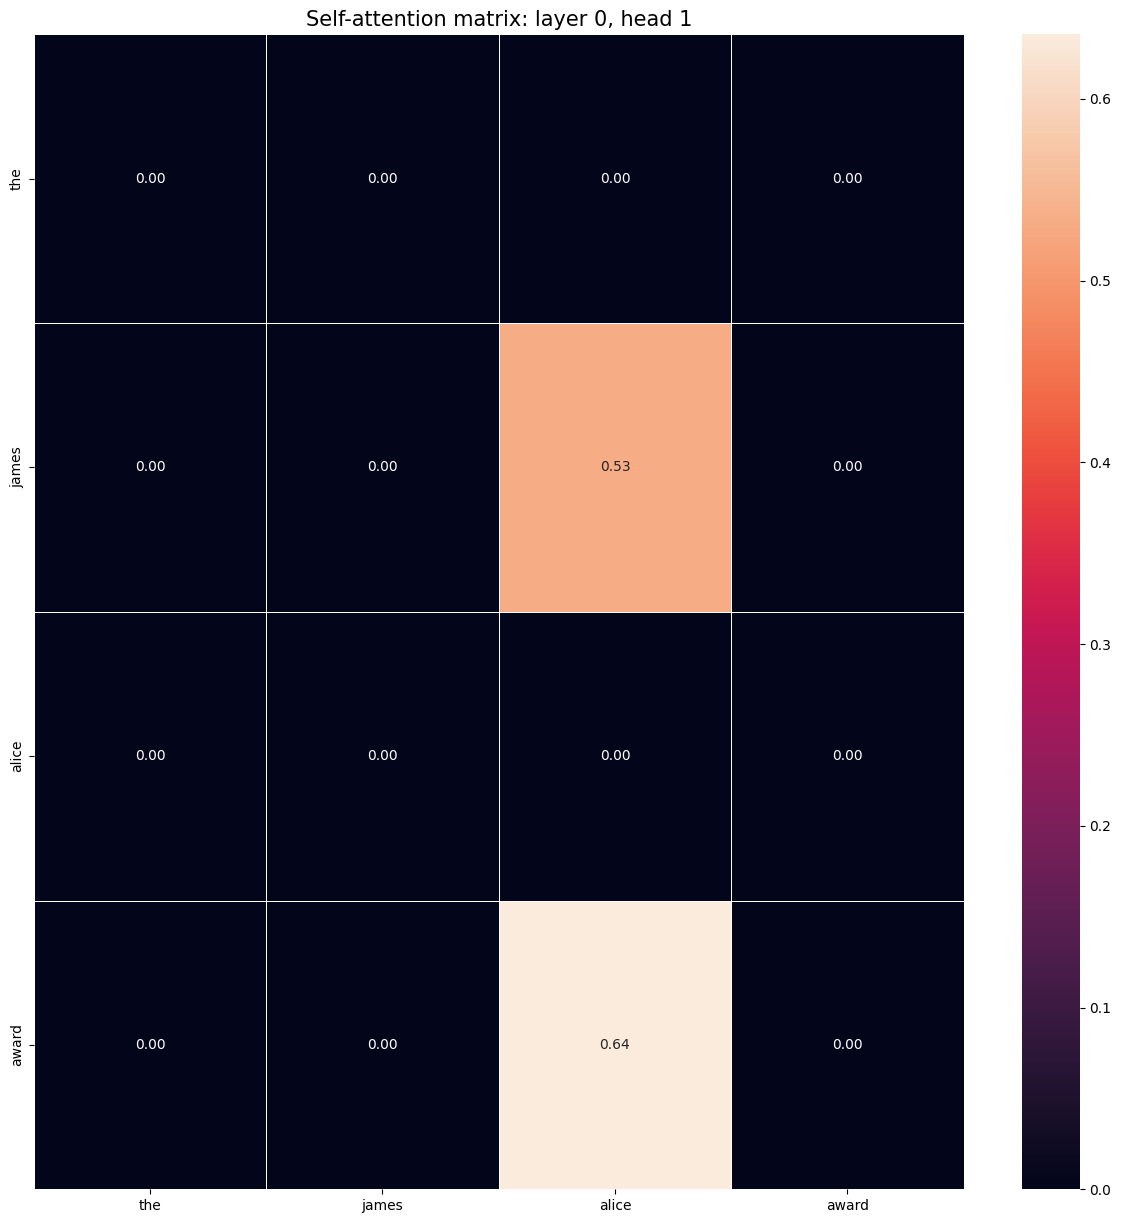

1
['james' 'alice']
torch.Size([6, 6])
torch.Size([6, 6])


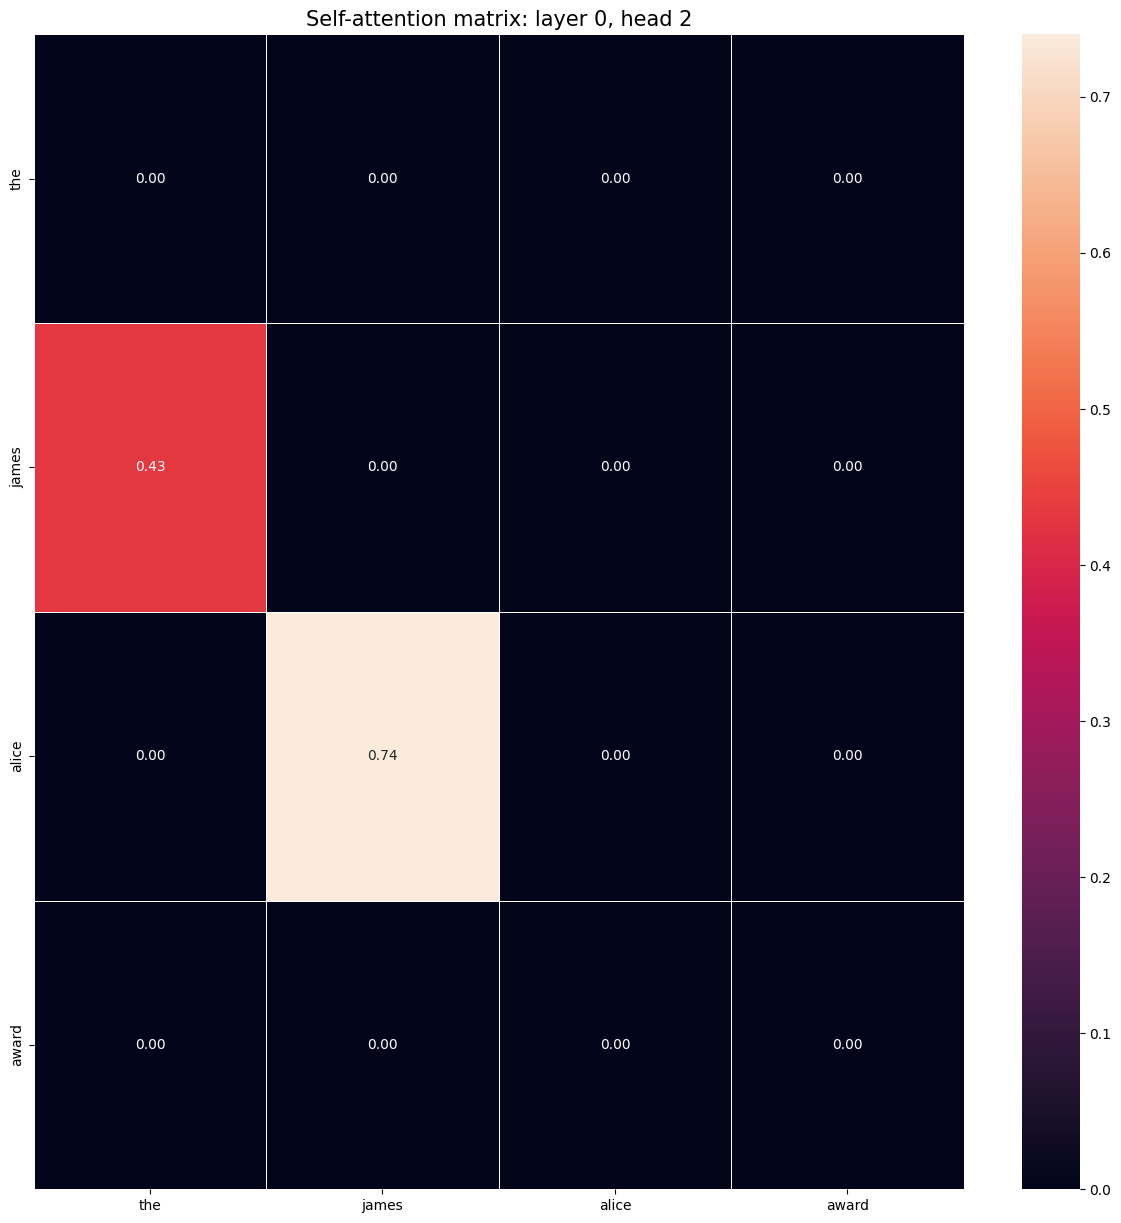

torch.Size([6, 6])
torch.Size([6, 6])


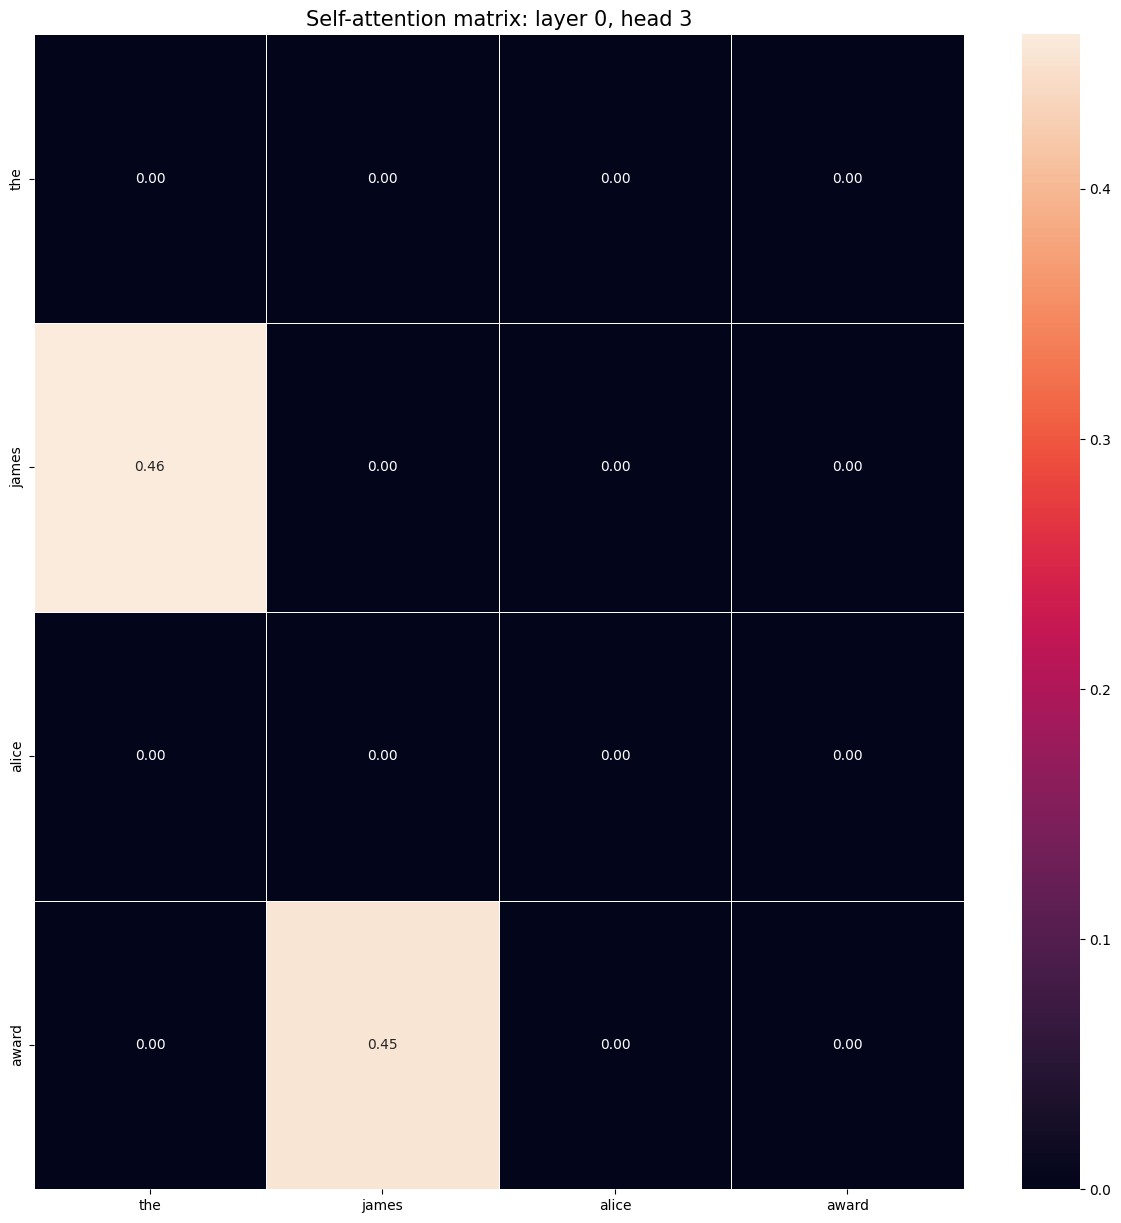

torch.Size([6, 6])
torch.Size([6, 6])


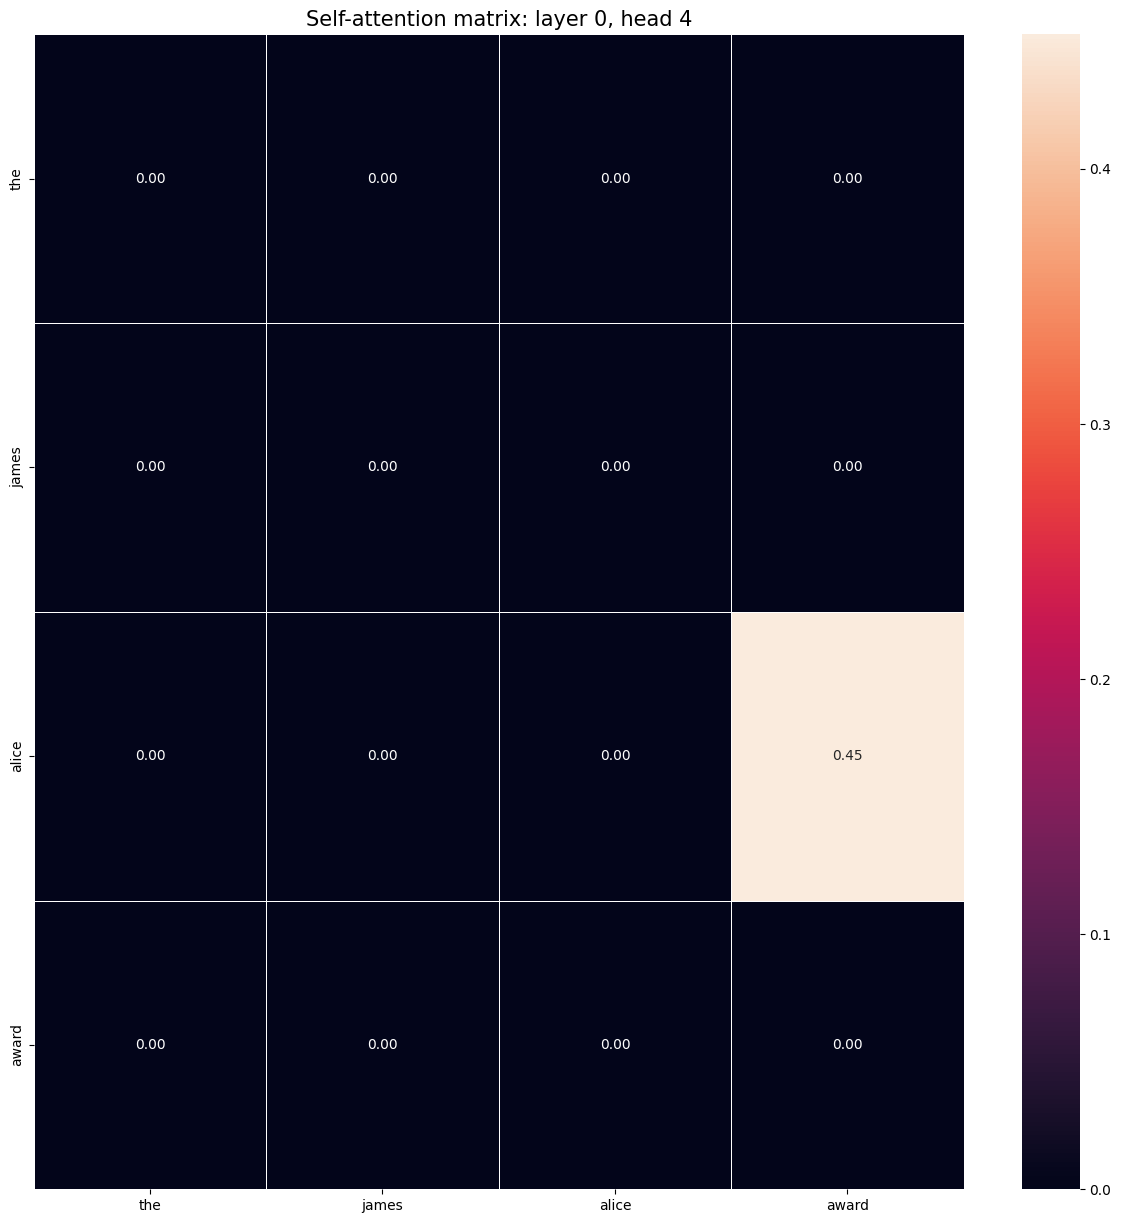

4
['alice' 'award']
torch.Size([6, 6])
torch.Size([6, 6])


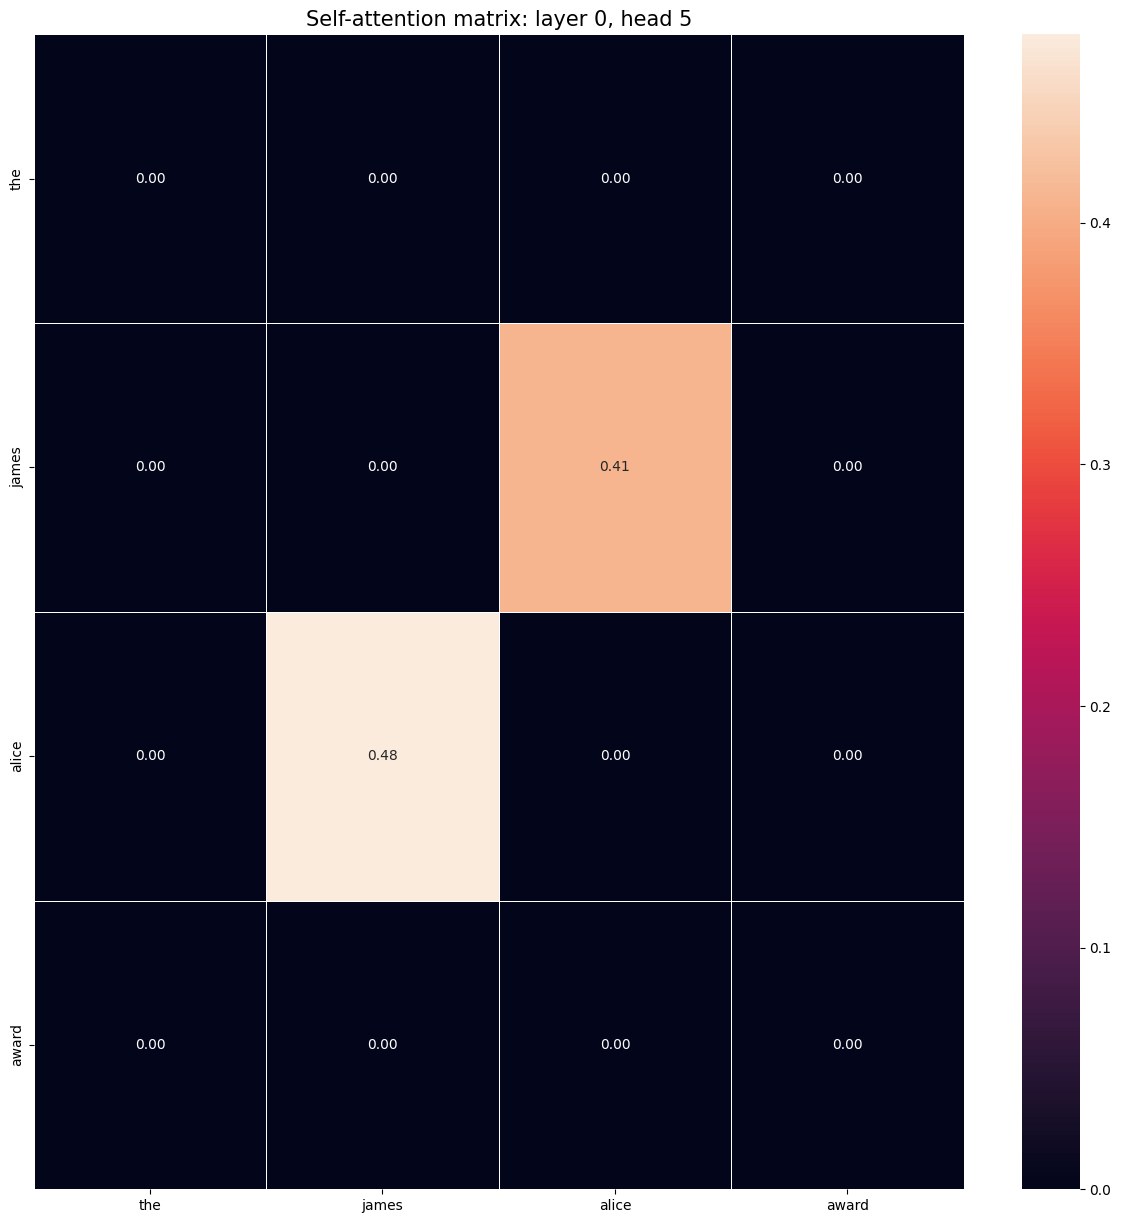

5
['james' 'alice']
torch.Size([6, 6])
torch.Size([6, 6])


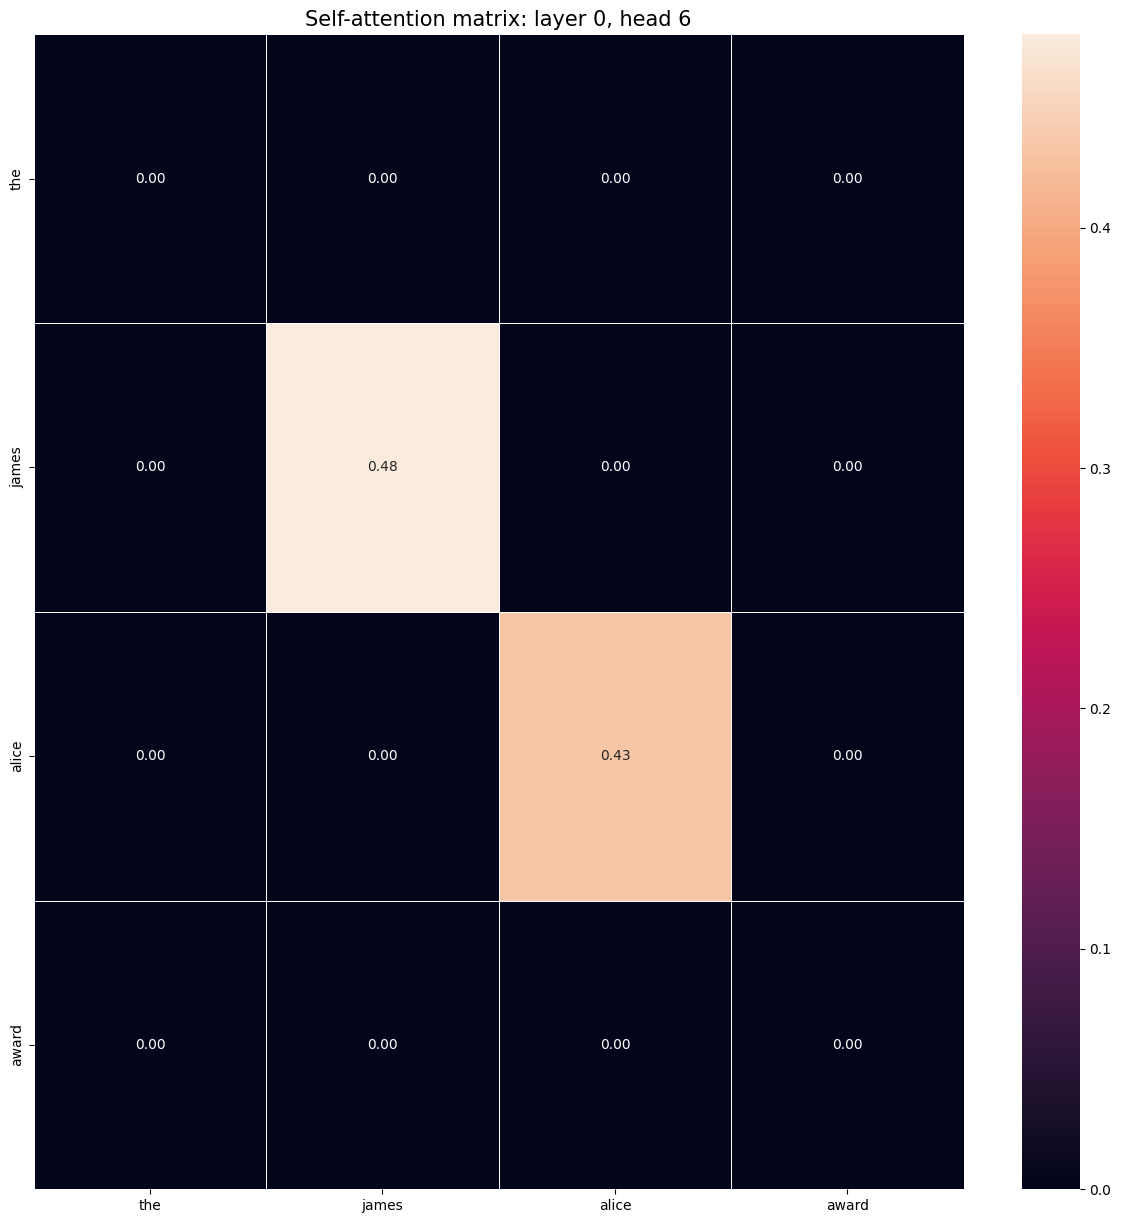

torch.Size([6, 6])
torch.Size([6, 6])


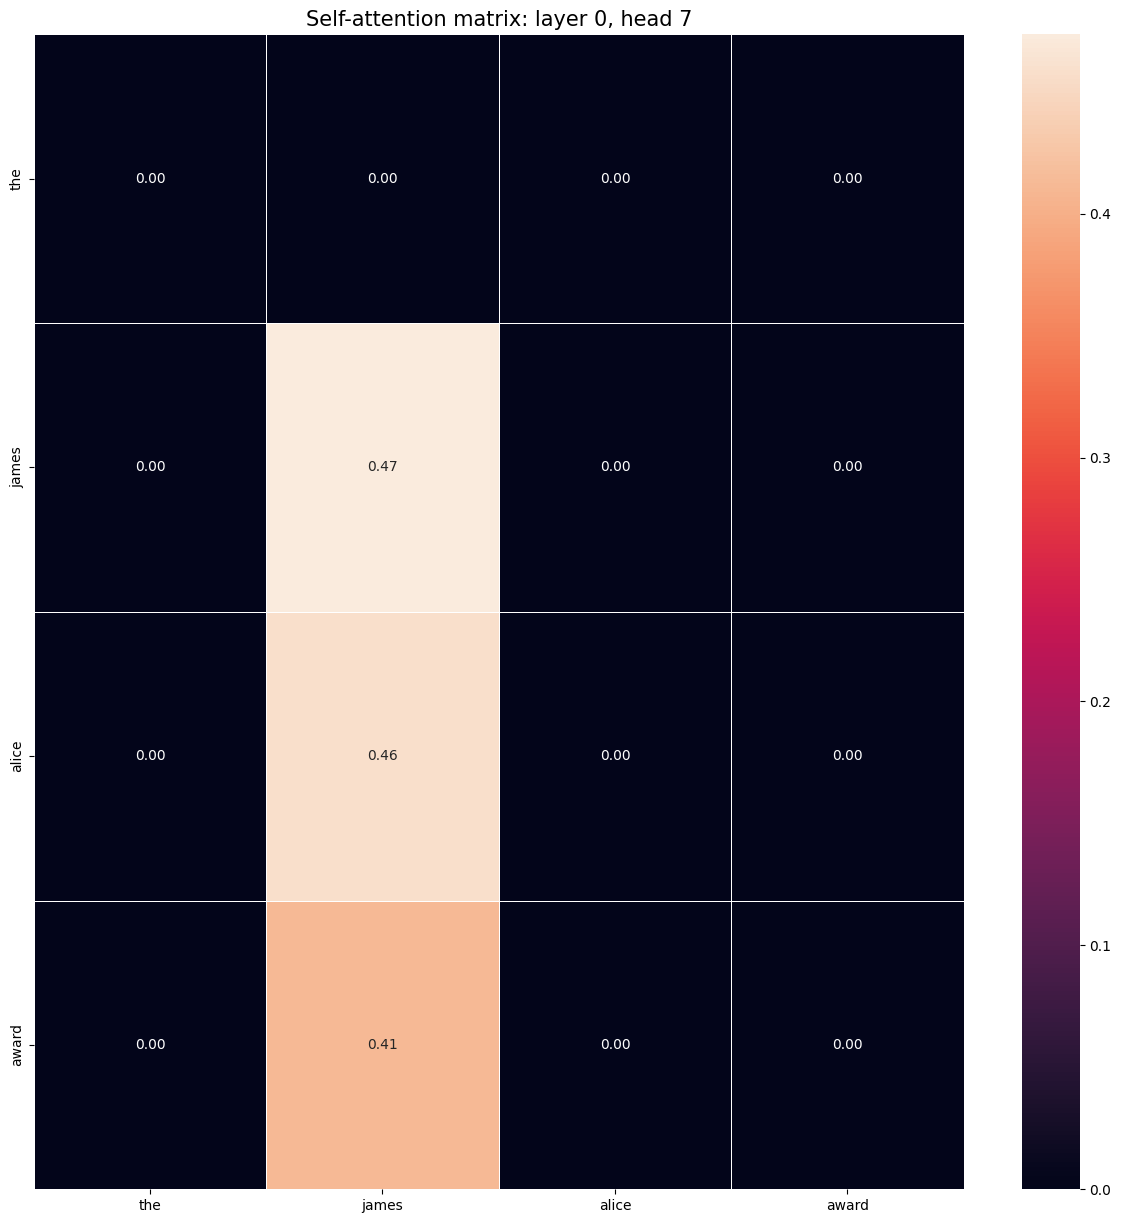

torch.Size([6, 6])
torch.Size([6, 6])


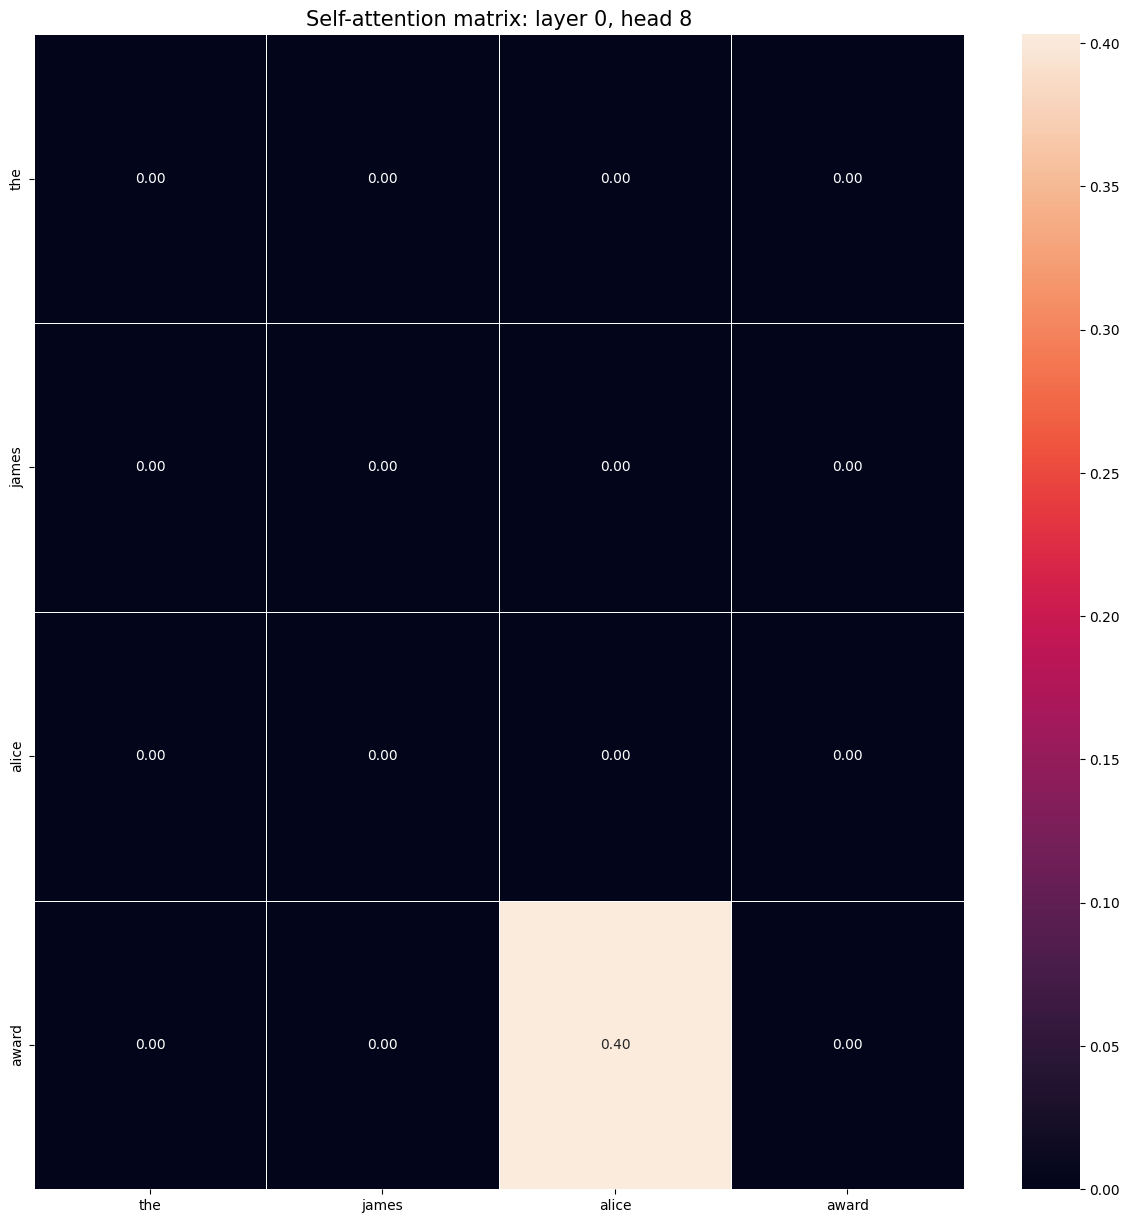

torch.Size([6, 6])
torch.Size([6, 6])


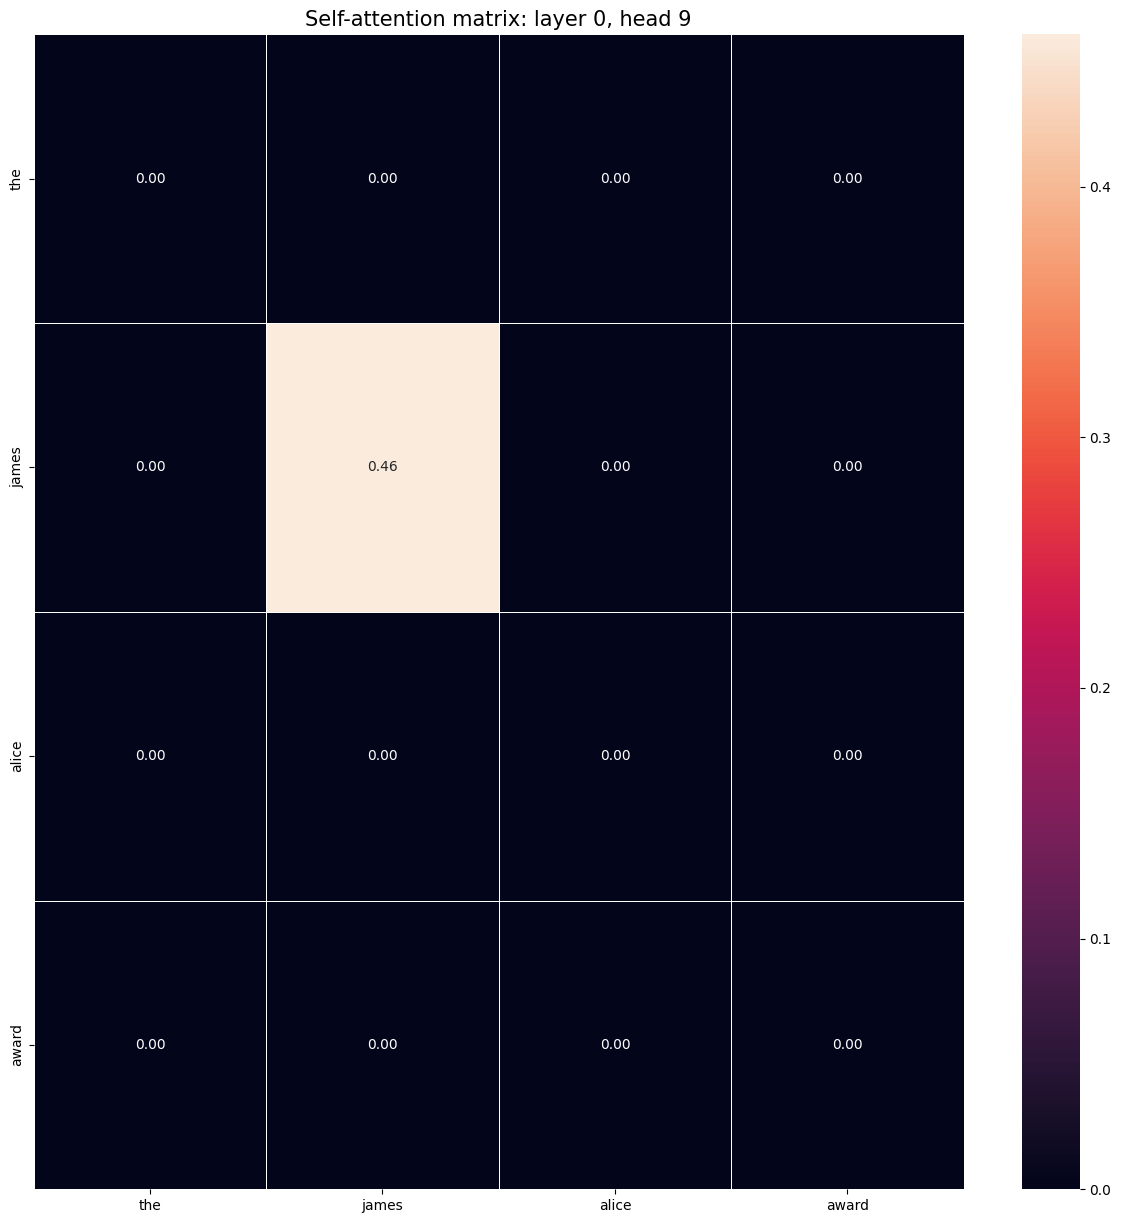

torch.Size([6, 6])
torch.Size([6, 6])


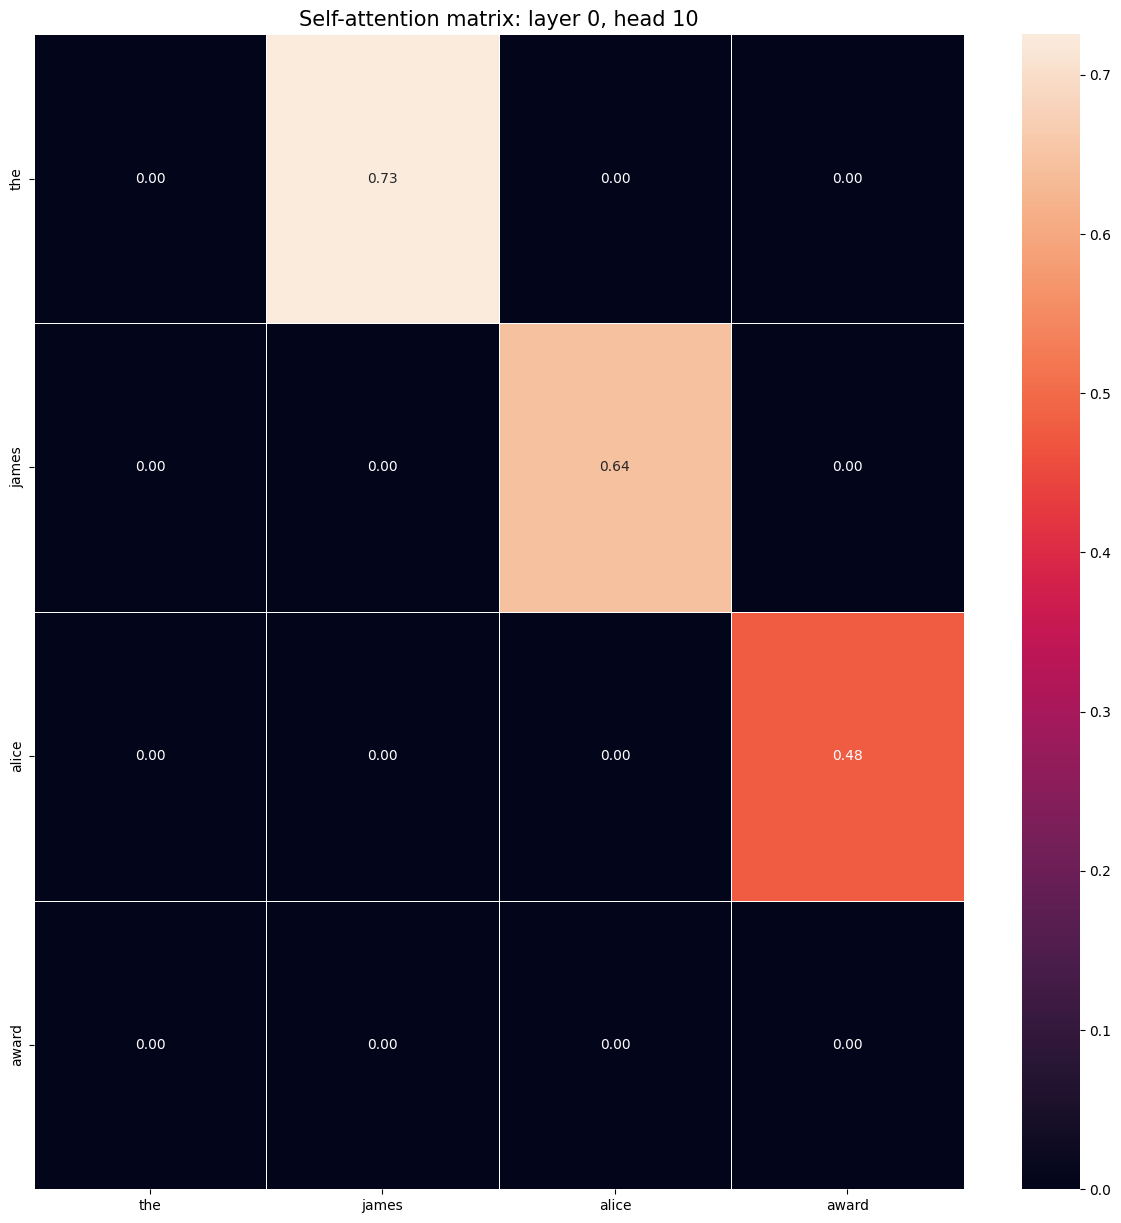

10
['the' 'james']
['the' 'james' 'alice']
['the' 'james' 'alice' 'award']
['james' 'alice']
['james' 'alice' 'award']
['alice' 'award']
torch.Size([6, 6])
torch.Size([6, 6])


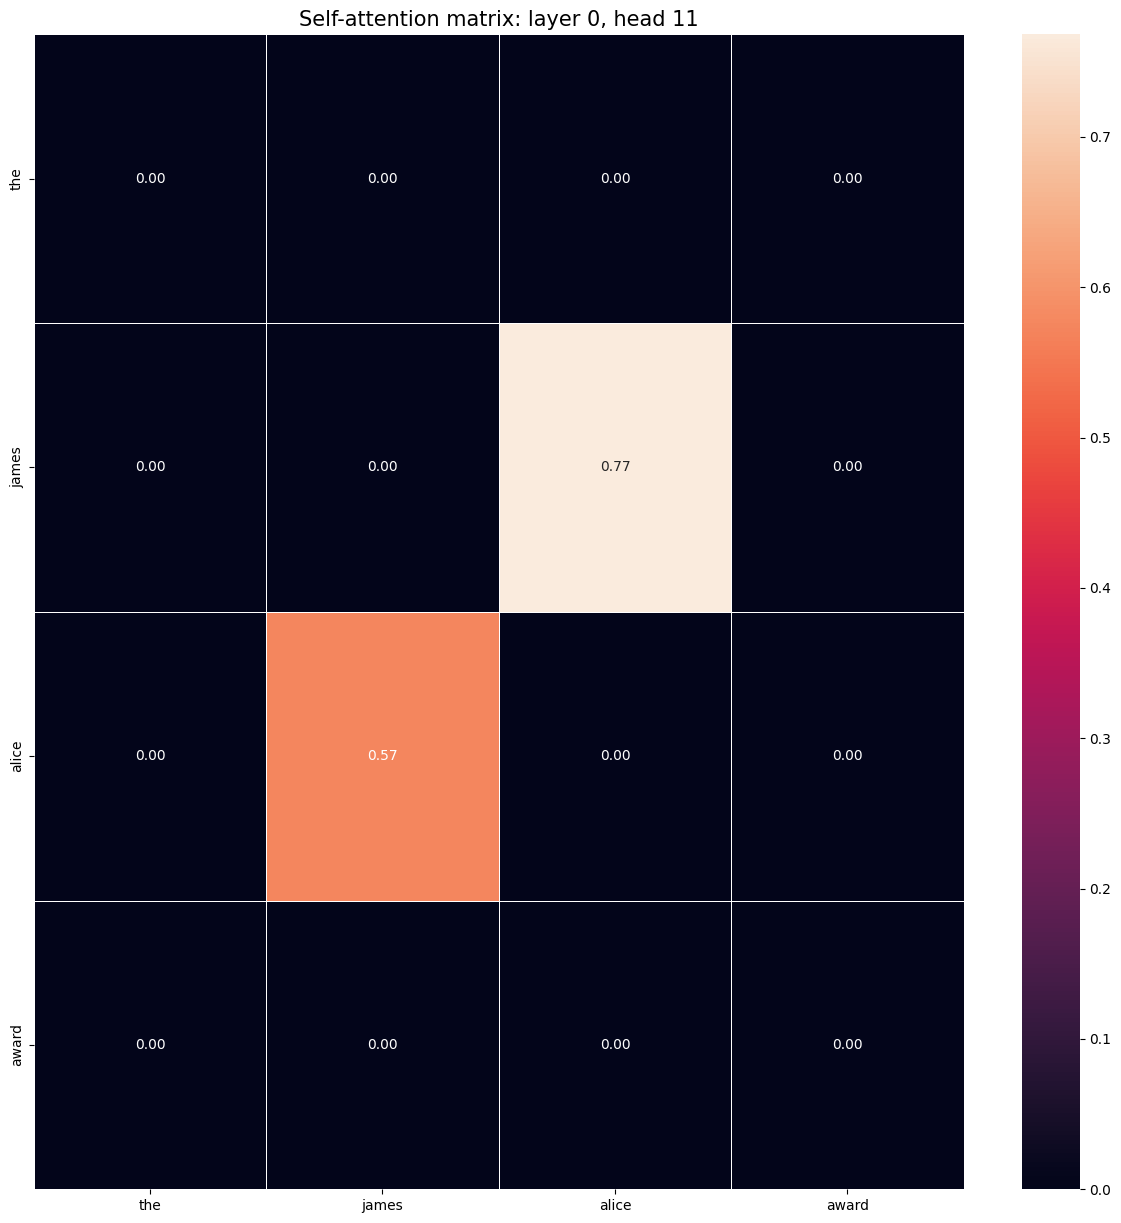

11
['james' 'alice']


In [42]:
layer = 0

for head in range(12):
    head_scores_raw_tensor = attention_matrix[layer][0][head]
    print(head_scores_raw_tensor.shape)
    # i = torch.tensor(averages_idx)
    # head_scores_raw_tensor[i] = torch.mean(head_scores_raw_tensor[i], dim=1, keepdim=True)
    # head_scores_raw_tensor = torch.unique_consecutive(head_scores_raw_tensor, dim=0)
    head_scores_raw_tensor = average_out_and_remove_consecutive_duplicates(head_scores_raw_tensor, averages_idx) # Row-wise avraging and duplicates removal
    # Transpose to apply the same operation to the columns. 
    head_scores_raw_tensor = torch.transpose(
        average_out_and_remove_consecutive_duplicates(torch.transpose(head_scores_raw_tensor, 0, 1), averages_idx),
        0,
        1
    ) # Tranpose the result of the tolumn-wise averaging and duplicates removal applied to transposed tensor.
    print(head_scores_raw_tensor.shape)
        
    head_scores_raw = head_scores_raw_tensor.cpu().detach().numpy()
    
    # Remove rows and columns coresponding to [CLS] and [SEP] tokens.
    head_scores = head_scores_raw[1:(len(head_scores_raw) - 1), 1:(len(head_scores_raw) - 1)].copy()
    #plot_heatmap(head_scores, labels)

    as_threshold = 0.4
    head_scores[head_scores < as_threshold] = 0
    plot_heatmap(head_scores, labels)
    
    G = nx.from_numpy_array(head_scores, create_using = nx.DiGraph())
    G.edges.data()

    sequences = []
    n_tokens = len(labels)
    construct_sequences(G, n_tokens)
    # if sequences != []:
    #     layer_sequences.append(sequences)
    if sequences != []:
        print(head)
        for seq in sequences:
            print(labels[seq.astype(bool)])

In [39]:
# text = "Firenze firenze"
# encoding = tokenizer.encode(text)
# labels = tokenizer.convert_ids_to_tokens(encoding)

In [40]:
# i = 0
# averages_idx = []
# while i < len(labels) - 1:
#     j = i + 1
#     average_idx = []
#     while labels[j].startswith('#'):
#         average_idx.append(j)
#         labels[i] += labels[j].replace('#', '')
#         j += 1
#     if average_idx != []:
#         average_idx.append(i)
#         averages_idx.append(average_idx)
#     i = j

# hashtag_idx = np.array([label.startswith("#") for label in labels])
# labels = np.array(labels)[~hashtag_idx]

In [26]:
# Torch implementation.

# t = torch.tensor(head_scores_raw)
# i = torch.tensor(averages_idx)

# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)
# t = torch.transpose(t, 0, 1)
# t[i] = torch.mean(t[i], dim=1, keepdim=True)
# t = torch.unique_consecutive(t, dim=0)

# t = torch.transpose(t, 0, 1)